# Проект: AB-тест для дейтингового приложения
    
В приложении есть базовые функции, премиум-подписка с доступом к дополнительным возможностям.
Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран  изменена стоимость премиум-подписки* при покупке через две новые платежные системы. 
<br>При этом стоимость пробного периода оставалась прежней.
<br>*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

<br><b> Цели: </b>
проверить успешность эксперимента в целом.

<br><b> Задачи: </b>
- провести анализ данных
- посчитать метрики
- оценить эксперимент

#### Ход работ:
- провести исследование данных (описательные: набор полей, тип данных, размер таблиц; качественные: проверка на пустые значения и дубликаты)
- сверить выполнение требований к эксперименту на датасетах
- подобрать метрики
- проанализировать распредление, оценить выбросы
- проверить корреляцию между типами оплат
- A/B-тест, оценка результатов, выводы, рекомендации

#### Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). 
<br>Для каждой из них:

<br><b><i>users_*.csv</i></b> – информация о пользователях:
<br><i>uid</i> – идентификатор пользователя
<br><i>age</i> – возраст
<br><i>attraction_coeff</i> – коэффициент привлекательности (от 0 до 1000, \${лайки}/{просмотры} * 1000$)
<br><i>coins</i> – число монеток (внутренняя валюта)
<br><i>country</i> – страна
<br><i>visit_days</i> – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
<br><i>gender</i> – пол
<br><i>age_filter_start</i>  – фильтр поиска, мин. значение 
<br><i>age_filter_end</i>  – фильтр поиска, макс. значение 
<br><i>views_count</i> – число полученных оценок 
<br><i>was_premium</i> – был ли когда-либо премиум (либо пробный период премиум-статуса, 
                                         либо купленный за деньги)
<br><i>is_premium</i> –  является ли премиум
<br><i>total_revenue</i> – нормированная выручка 

<br><b><i>transactions_*.csv</i></b> – информация о платежах пользователей:
<br><i>uid</i> – идентификатор пользователя
<br><i>country</i> – страна
<br><i>joined_at</i> – дата и время регистрации
<br><i>paid_at</i> – дата и время покупки
<br><i>revenue</i> – нормированная выручка
<br><i>payment_id</i> – идентификатор платежа
<br><i>from_page</i> – откуда пользователь перешел на страницу оплаты
<br><i>product_type</i> – тип продукта (trial_premium – пробная премиум-подписка, 
                             premium_no_trial – премиум-подписка без пробной, 
                             coins – подписка за внутреннюю валюту, 
                             other_type – другое) 

#### Файлы:
<br><i>users_test</i> – информация о пользователях в тестовой группе. 
<br><i>users_control_1</i> – информация о пользователях в первой контрольной группе. 
<br><i>users_control_2</i> – информация о пользователях во второй контрольной группе . 
<br><i>transactions_test</i> – информация о платежах пользователей в тестовой группе. 
<br><i>transactions_control_1</i> – информация о платежах пользователей в первой контрольной группе. 
<br><i>transactions_control_2</i> – информация о платежах пользователей во второй контрольной группе 

## Работа с исходными данными

In [78]:
# блок импорта библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import norm
# import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm.auto import tqdm

In [3]:
# скрываем предупреждения
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Загрузка источников
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key1 = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'  # ссылка на яндекс диск
public_key2 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
public_key3 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
public_key4 = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
public_key5 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
public_key6 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

def source(link_yd, fl=True):
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=link_yd))
    response = requests.get(final_url)
    download_url = response.json()['href']
    if fl:
        return pd.read_csv(download_url, sep=';')  # условие для чтения источника по пользователям
    else:
        return pd.read_csv(download_url, sep=';', parse_dates = ['joined_at', 'paid_at'])  # условие для чтения источника по транзакциям

user_test = source(public_key1)
user_control1 = source(public_key2)
user_control2 = source(public_key3)
transactions_test = source(public_key4, False)
transactions_control1 = source(public_key5, False)
transactions_control2 = source(public_key6, False)

In [5]:
# размер датасетов
print(f'size')
print(f'user_test  {user_test.shape}')
print(f'user_control1  {user_control1.shape}')
print(f'user_control2  {user_control2.shape}')
print(f'transactions_test  {transactions_test.shape}')
print(f'transactions_control1  {transactions_control1.shape}')
print(f'transactions_control2  {transactions_control2.shape}')

size
user_test  (4308, 13)
user_control1  (4340, 13)
user_control2  (4264, 13)
transactions_test  (273, 8)
transactions_control1  (1007, 8)
transactions_control2  (328, 8)


In [6]:
# структура дата сета по пользователям
user_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [7]:
# тип данных в дата сете по пользователям
user_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

Пустые значения в дата сете по пользователям в колонках coins, visit_days, was_premium, is_premium допустимы.

In [8]:
# проверка на пустые значения дата сета по пользователям
user_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [9]:
user_control1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [10]:
user_control2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [11]:
# проверка на дубликаты, в таблицах по пользователям дубликатов нет
user_test.loc[user_test.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [12]:
user_control1.loc[user_control1.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [13]:
user_control2.loc[user_control2.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [14]:
# структура дата сета по транзакциям
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [15]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [16]:
# проверка на пустые значения дата сета по транзакциям
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

В датасете transactions_control1 найдены пустые значения, это пустые строки, убираем такие строки

In [17]:
transactions_control1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [18]:
transactions_control1.tail()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1006,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [19]:
transactions_control1 = transactions_control1.dropna()
transactions_control1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [20]:
transactions_control2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

В таблицах по транзакциям выявлены дубликаты по product_type other и coins. Так как совпадение до секунд, допускаем, что это реальные дубликаты, возможно из-за особенностей системы сбора данных. Дубликаты убираем, чтобы исключить смещение в доходах от покупателя (revenue).

In [21]:
# проверка на дубликаты
transactions_test.loc[transactions_test.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
243,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins


In [22]:
transactions_control1.loc[transactions_control1.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
93,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
176,892207959.0,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261.0,19.0,empty_likes,coins
198,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
206,891739737.0,United States of America,2017-10-28 18:50:00,2017-11-13 05:34:00,1261.0,19.0,empty_likes,coins
216,891452706.0,Italy,2017-03-11 14:48:00,2017-11-11 17:21:00,6305.0,19.0,gifts,coins
223,891721851.0,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897.0,19.0,empty_likes,coins
233,891365490.0,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins


In [23]:
transactions_control2.loc[transactions_control2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


In [24]:
transactions_test = transactions_test.drop_duplicates()
transactions_control1 = transactions_control1.drop_duplicates()
transactions_control2 = transactions_control2.drop_duplicates()

## Check up требований к исследованию

<b>Условия эксперимента:</b>
<br>1)Исследование для новых пользователей
<br>2)Ограниченный список стран
<br>3)Изменяемая feature - стоимость премиум-подписки
<br>4)2 новые системы оплаты

<b>1)Исследование для новых пользователей</b>
<br><b>1.1)</b> Новых пользователей можно определить по времени с момента регистрации, например разница между joined_at и paid_at не больше N дней.
<br> Проверим дельту между датой регистрации и датой оплаты.
<br><b>1.2)</b> Другой способ считать новым пользователем любого, кто не пробовал премиум-подписку ранее. 
<br>Есть отметка was_premium, без привязки к периоду. 
<br>Проверим отметку was_premium для пользователей, у которых во время эксперимента не было премиум подписки. Если найдём таких пользователей, они не подходят под критерий "новый", у них уже была подписка.
<br>Все остальные подписки премиум считаем в рамках эксперимента и выбранного периода 2017 год.

In [25]:
# период регистрации пользователей попадает с января17 по октябрь17
transactions_test.joined_at.describe()

count                     266
unique                    146
top       2017-10-18 01:09:00
freq                       11
first     2017-01-11 03:07:00
last      2017-10-31 23:40:00
Name: joined_at, dtype: object

In [26]:
transactions_control1.joined_at.describe()

count                     356
unique                    193
top       2017-10-16 01:38:00
freq                       19
first     2015-01-19 11:49:00
last      2017-10-31 22:17:00
Name: joined_at, dtype: object

In [27]:
transactions_control2.joined_at.describe()

count                     323
unique                    187
top       2017-10-30 15:22:00
freq                       11
first     2017-01-11 08:36:00
last      2017-10-31 17:43:00
Name: joined_at, dtype: object

<br><b>1.1)</b> Проверяем дельту между датой регистрации и датой оплаты.

In [28]:
# заводим поле с разницей дат
transactions_test = transactions_test.assign(date_dif = transactions_test.paid_at - transactions_test.joined_at)
transactions_test.date_dif.unique()

array([ 16077840000000000,    695040000000000,    428760000000000,
          854940000000000,    698400000000000,    131160000000000,
        23608680000000000,  18496800000000000,      6720000000000,
             420000000000,    146340000000000,  -1238100000000000,
         2743140000000000,    613260000000000,    263160000000000,
         2463600000000000,    191700000000000,    421140000000000,
        18324000000000000,     83400000000000, -19864740000000000,
        13220940000000000,     22620000000000,    221700000000000,
       -19864800000000000,  -6211140000000000,   5246280000000000,
           94680000000000,     75780000000000,   4547700000000000,
            9180000000000,       720000000000,    612000000000000,
        10887540000000000,   1153800000000000,    698820000000000,
        -4314720000000000, -16800540000000000,  -6126900000000000,
          519600000000000,    802560000000000,   2683560000000000,
        23608860000000000,   5265180000000000,    267720000000

In [29]:
transactions_test.head(20)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,date_dif
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,186 days 02:04:00
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,8 days 01:04:00
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,4 days 23:06:00
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,9 days 21:29:00
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,8 days 02:00:00
5,892426491,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597,147,autoreply_message,premium_no_trial,1 days 12:26:00
6,891558921,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial,273 days 05:58:00
7,891322086,United States of America,2017-05-11 19:20:00,2017-12-11 21:20:00,9919,147,trial_vip_popup,trial_premium,214 days 02:00:00
8,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:13:00,1261,19,autorefill,coins,0 days 01:52:00
9,892202526,United States of America,2017-10-18 20:34:00,2017-10-18 20:41:00,897,146,ad_to_photo,coins,0 days 00:07:00


In [30]:
# смотрим разброс мин и макс значения
transactions_test.date_dif.describe()

count                            266
mean       0 days 03:25:04.060150375
std      105 days 02:24:49.510038614
min              -288 days +02:12:00
25%                  0 days 00:12:00
50%                  2 days 02:17:30
75%                 12 days 15:23:45
max                302 days 00:42:00
Name: date_dif, dtype: object

Обнаружены отрицательные значения по разнице дат, т.е. есть строки, где дата покупки раньше даты регистрации.
<br>Нужно исключить таких пользователей. 
<br>В дальнейшем выяснить причину/найти объяснение случаев, где дата оплаты раньше даты регистрации - сбой, нормальная особенность порядка событий (регистрация необязательна, пользователь это просто посетитель), затерта/потеряна часть логов.

In [31]:
# делаем список uid для исключения пользователей
uid_list = list(transactions_test.query('date_dif < "0 days"').uid.unique())

# исключаем строки из transactions_test
transactions_test = transactions_test.query('uid not in @uid_list')

# исключаем пользователей из user_test
user_test = user_test.query('uid not in @uid_list')

In [32]:
# прорабатываем такй же кейс с датой оплаты раньше даты регистрации для датасета control1

# заводим поле с разницей дат
transactions_control1 = transactions_control1.assign(date_dif = transactions_control1.paid_at - transactions_control1.joined_at)

# смотрим разброс мин и макс значения
transactions_control1.date_dif.describe()

count                            356
mean      13 days 02:03:34.382022472
std      116 days 00:16:14.200656952
min              -289 days +18:23:00
25%                  0 days 00:21:45
50%                  2 days 21:10:30
75%                 30 days 11:09:30
max                695 days 05:46:00
Name: date_dif, dtype: object

In [33]:
# делаем список uid для исключения пользователей
uid_list = list(transactions_control1.query('date_dif < "0 days"').uid.unique())

# исключаем строки из transactions_control1
transactions_control1 = transactions_control1.query('uid not in @uid_list')

# исключаем пользователей из user_control1
user_control1 = user_control1.query('uid not in @uid_list')

In [34]:
# прорабатываем такой же кейс с датой оплаты раньше даты регистрации для датасета control2

# заводим поле с разницей дат
transactions_control2 = transactions_control2.assign(date_dif = transactions_control2.paid_at - transactions_control2.joined_at)

# смотрим разброс мин и макс значения
transactions_control2.date_dif.describe()

count                             323
mean     -15 days +02:03:21.547987616
std        96 days 19:28:42.838963630
min               -293 days +21:12:00
25%                   0 days 00:10:30
50%                   1 days 09:51:00
75%                   7 days 02:19:30
max                 214 days 02:04:00
Name: date_dif, dtype: object

In [35]:
# делаем список uid для исключения пользователей
uid_list = list(transactions_control2.query('date_dif < "0 days"').uid.unique())

# исключаем строки из transactions_control1
transactions_control2 = transactions_control2.query('uid not in @uid_list')

# исключаем пользователей из user_control1
user_control2 = user_control2.query('uid not in @uid_list')

<br><b>1.2)</b> Проверяем отметку was_premium для пользователей, у которых во время эксперимента не было премиум подписки.

In [36]:
# для test
# готовим список пользователей хотя бы с одной покупкой премиум подписки
premium_id = list(transactions_test
                  .query('product_type in ["trial_premium", "premium_no_trial"]')
                  .uid
                  .unique())

# отбираем строки без премиум подписок, добавляем поля из таблицы user_test, фильтруем по was_premium = 1, преобразовываем в список uid
was_premium_uid = list(transactions_test
    .query('uid not in @premium_id')
    .merge(user_test, on='uid')
    .query('was_premium == 1')
    .uid
    .unique())


# исключаем новый список uid из датасетов - пользователей с подпиской премиум в прошлых периодах не считаем новыми
user_test = user_test.query('uid not in @was_premium_uid')
transactions_test = transactions_test.query('uid not in @was_premium_uid')

In [37]:
# для control1
# готовим список пользователей хотя бы с одной покупкой премиум подписки
premium_id = list(transactions_control1
                  .query('product_type in ["trial_premium", "premium_no_trial"]')
                  .uid
                  .unique())

# отбираем строки без премиум подписок, добавляем поля из таблицы user_test, фильтруем по was_premium = 1, преобразовываем в список uid
was_premium_uid = list(transactions_control1
    .query('uid not in @premium_id')
    .merge(user_control1, on='uid')
    .query('was_premium == 1')
    .uid
    .unique())


# исключаем новый список uid из датасетов - пользователей с подпиской премиум в прошлых периодах не считаем новыми
user_control1 = user_control1.query('uid not in @was_premium_uid')
transactions_control1 = transactions_control1.query('uid not in @was_premium_uid')

In [38]:
# для control1
# готовим список пользователей хотя бы с одной покупкой премиум подписки
premium_id = list(transactions_control2
                  .query('product_type in ["trial_premium", "premium_no_trial"]')
                  .uid
                  .unique())

# отбираем строки без премиум подписок, добавляем поля из таблицы user_test, фильтруем по was_premium = 1, преобразовываем в список uid
was_premium_uid = list(transactions_control2
    .query('uid not in @premium_id')
    .merge(user_control2, on='uid')
    .query('was_premium == 1')
    .uid
    .unique())


# исключаем новый список uid из датасетов - пользователей с подпиской премиум в прошлых периодах не считаем новыми
user_control2 = user_control2.query('uid not in @was_premium_uid')
transactions_control2 = transactions_control2.query('uid not in @was_premium_uid')

<b>2)Ограниченный список стран</b>
<br>Для всех датасетов отбираем строки только с общими странами, которые есть в user таблицах. Так мы проверим одинаковый набор стран, таблицы transaction фильтруем по этому же списку для чистоты условия, т.к. допускаем, что в выборках могут быть страны с неплатящими пользователями.

In [39]:
# создаём список стран
country_list = pd.DataFrame(user_test.country.unique()) \
    .merge(pd.DataFrame(user_control1.country.unique()), how='inner') \
    .merge(pd.DataFrame(user_control2.country.unique()), how='inner')
country_list = list(country_list[0])

In [40]:
user_test = user_test.query('country in @country_list')
user_control1 = user_control1.query('country in @country_list')
user_control2 = user_control2.query('country in @country_list')
transactions_control1 = transactions_control1.query('country in @country_list')
transactions_control2 = transactions_control2.query('country in @country_list')

<b>3)Изменяемая feature - стоимость премиум-подписки</b>
<br>Для метрик, расчитываемых по премиум-подписке, используем product_type = premium_no_trial, так как стоимость пробного периода (trial_premium) не изменилась.
<br>Применение фильтра определим в блоке корреляционного анализа и дальнейших шагах.

In [41]:
transactions_control1.product_type.unique()

array(['trial_premium', 'coins', 'premium_no_trial', 'other_type'],
      dtype=object)

<b>4)2 новые системы оплаты</b>
<br>В датасетах по транзакциям выявлено 2 вида оплат payment_id 147 и 68, а также встретились единичные оплаты с кодом 0, исключим их.
Отметок о совершении покупки новой системой оплаты в датасетах нет. Косвенно (по суммам дохода и payment_id) закономерностей в оплатах не выявлено. Принимаем факт, что у пользователя был выбор систем оплат.

In [42]:
# уникальные значения 'country', 'product_type', 'payment_id', 'revenue' в тестовом датасете транзакций
transactions_test \
    .query('product_type =="premium_no_trial"')[['country', 'product_type', 'payment_id', 'revenue']] \
    .drop_duplicates() \
    .sort_values(['country', 'product_type', 'payment_id'])

,country,product_type,payment_id,revenue
95,Argentina,premium_no_trial,147,5330
121,Argentina,premium_no_trial,147,12597
267,Argentina,premium_no_trial,147,6292
83,Canada,premium_no_trial,147,4706
253,Canada,premium_no_trial,147,12597
79,Chile,premium_no_trial,147,8086
120,Chile,premium_no_trial,147,8216
171,Chile,premium_no_trial,147,8229
246,Chile,premium_no_trial,147,8268
126,France,premium_no_trial,147,7930


In [43]:
# уникальные значения 'country', 'product_type', 'payment_id', 'revenue' в control1 датасете транзакций
transactions_control1 \
    .query('product_type =="premium_no_trial"')[['country', 'product_type', 'payment_id', 'revenue']] \
    .drop_duplicates() \
    .sort_values(['country', 'product_type', 'payment_id']) \
    .head(50)

,country,product_type,payment_id,revenue
36,Argentina,premium_no_trial,147.0,5278.0
105,Argentina,premium_no_trial,147.0,6292.0
44,Australia,premium_no_trial,68.0,3588.0
312,Canada,premium_no_trial,68.0,3549.0
212,Canada,premium_no_trial,147.0,4706.0
371,Canada,premium_no_trial,147.0,6292.0
15,Chile,premium_no_trial,147.0,6292.0
217,Chile,premium_no_trial,147.0,4745.0
347,France,premium_no_trial,0.0,6422.0
46,France,premium_no_trial,68.0,2717.0


In [44]:
transactions_test = transactions_test.query('payment_id != 0')
transactions_control1 = transactions_control1.query('payment_id != 0')
transactions_control2 = transactions_control2.query('payment_id != 0')

#### EDA overview
В ходе разведывательного анализа и предобработки датасетов были выявлены и удалены:
- строки с пропущенными значениями в transactions_control1, 
- строки с дубликатами в датасетах с транзакциями,
- пользователи, у которых в таблицах транзакций дата покупки > даты авторизации,
- пользователи, не подключавшие премиум в исследуемом периоде, но имеющие флаг was_premium (были премиум в прошлом) - такие пользователи не соответствуют условиям,
- отфильтрованы пользователи из стран, входящих во все выборки по user,
- исключены непромаркированные типы оплат 0

## Метрики

В рамках эксперимента у пользователя произошло 2 изменения:
    <br>1)Дополнена механика оплаты - функциональное изменение
    <br>2)Изменена стоимость оплаты - экономика
<br>Мы оцениваем эти изменения совместно, но так как они оба касаются шага оплаты, можно выбрать общую денежную метрику.

В качестве основной метрики используем средний доход на пользователя <i>ARPU</i>, т.к. этот показатель учитывает и изменения пользователей в покупателей и изменение доходов от покупателя.
<br>\${ARPU} = {Доходы} / {ВсегоПользователей}\$
<br>Средний чек мог бы также напрямую показывать изменения в доходах, но это изменение в любом случае будет, т.к. поменялась цена подписки, мы можем даже получить снижение среднего чека, но общий эффект не изменится.
<br>В качестве вспомогательных прокси-метрик возьмём <i>CR</i> конверсию из пользователя в покупателя и средний доход на покупателя <i>ARPPU</i>. 
<br>\${CR} = {Покупатели} / {ВсегоПользователей}\$
<br>\${ARPPU} = {Доходы} / {Покупатели}\$
<br>Оценим их в динамике, чтобы посмотреть за счёт чего изменится ARPU - из-за конверсии или из-за суммы дохода.
<br>\${ARPU} = {Конверсия} * {ARPPU}\$
<br>Далее оценим корреляцию между доходами от типов продуктов и определимся в необходимости оценивать общий эфффект на ARPU или работать только с премиум-подпиской.

## Оценка распределений контрольных датасетов

На контрольных датасетах user_control оценено распределение количества пользователей по социально-демографическим признакам возрасту/стране/полу.
<br>В результате оценки пришли к выводу об идентичности выборок.

In [45]:
#для распределения пользователей по возрастному признаку 
age_c1 = user_control1.groupby('age', as_index=False).agg({'uid': 'count'})
age_c2 = user_control2.groupby('age', as_index=False).agg({'uid': 'count'})

#для распределения пользователей по странам 
country_c1 = user_control1.groupby('country', as_index=False).agg({'uid': 'count'})
country_c2 = user_control2.groupby('country', as_index=False).agg({'uid': 'count'})

#для распределения пользователей по половому признаку 
gender_c1 = user_control1.groupby('gender', as_index=False).agg({'uid': 'count'})
gender_c2 = user_control2.groupby('gender', as_index=False).agg({'uid': 'count'})

#для распределения пользователей по привлекательности
attr_c1 = user_control1.groupby('attraction_coeff', as_index=False).agg({'uid': 'count'})
attr_c2 = user_control2.groupby('attraction_coeff', as_index=False).agg({'uid': 'count'})

In [46]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(25,5)}
        )

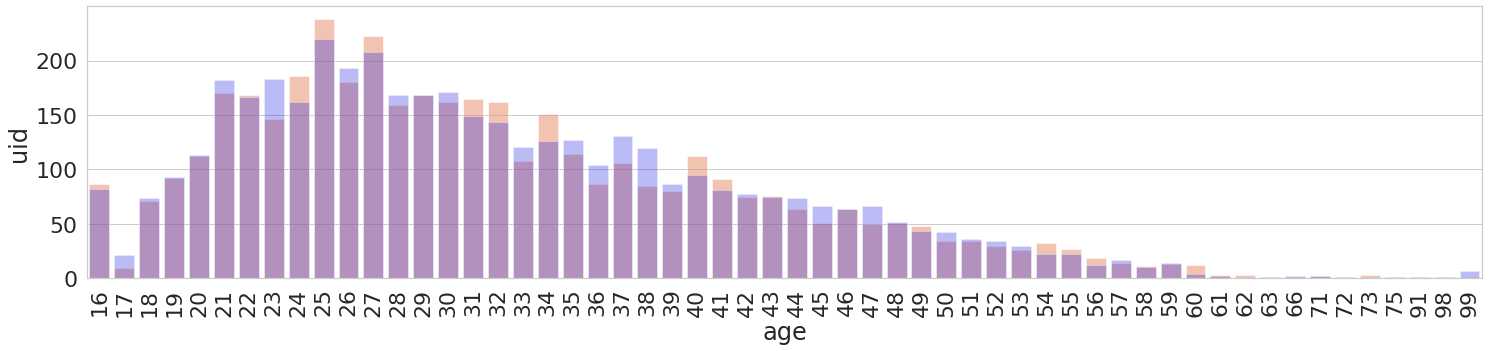

In [47]:
# распределение пользователей по возрастам
plt.xticks(rotation=90)
sns.barplot(x='age', y='uid', data=age_c2, color='coral', alpha=0.5)
sns.barplot(x='age', y='uid', data=age_c1, color='blue', alpha=0.3)

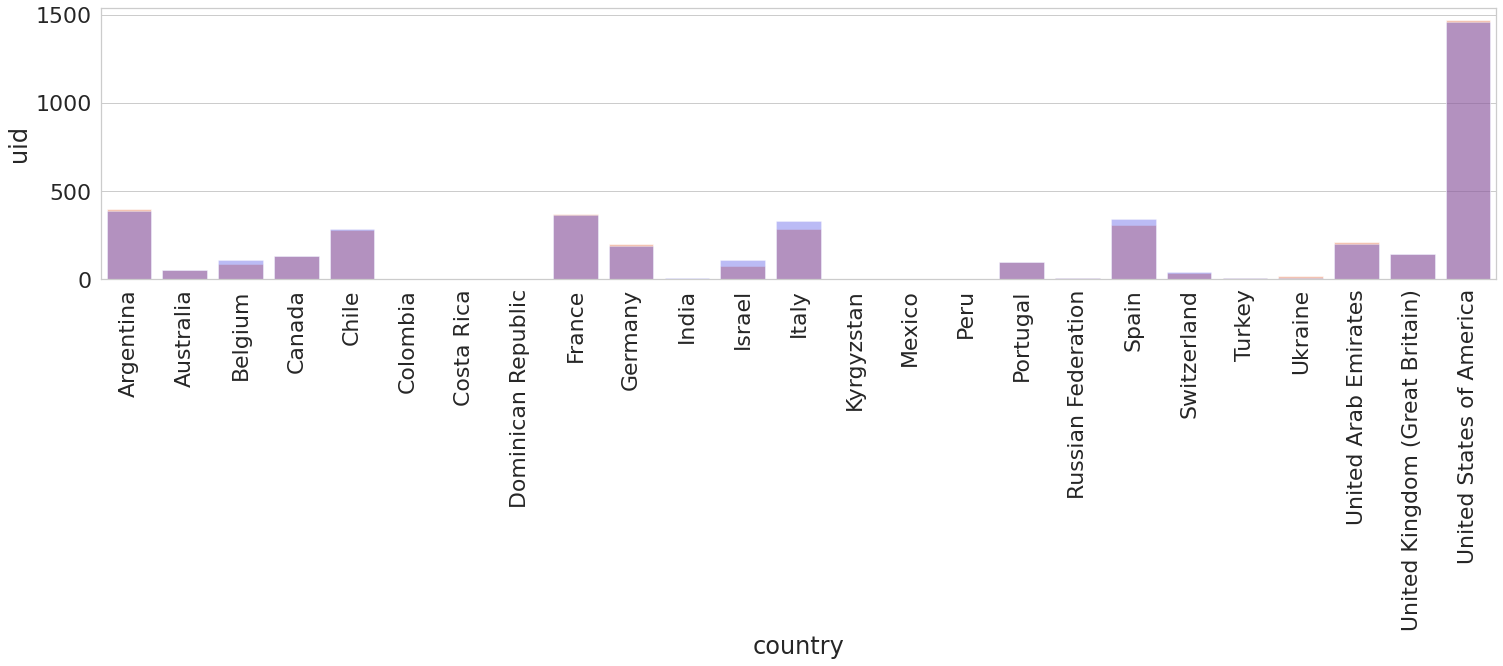

In [48]:
# распределение пользователей по странам
plt.xticks(rotation=90)
sns.barplot(x='country', y='uid', data=country_c2, color='coral', alpha=0.5)
sns.barplot(x='country', y='uid', data=country_c1, color='blue', alpha=0.3)

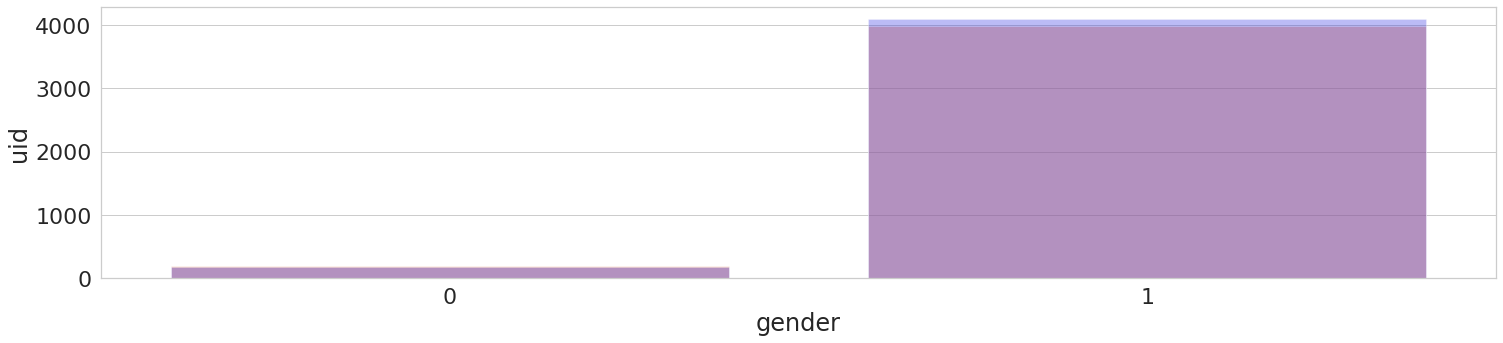

In [49]:
# распределение пользователей по полу
sns.barplot(x='gender', y='uid', data=gender_c2, color='coral', alpha=0.5)
sns.barplot(x='gender', y='uid', data=gender_c1, color='blue', alpha=0.3)

По графикам возраст/страна/пол видно, что распределение пользователей близко сходится между контрольными датасетами.
<br>Распределение по привлекательности прогоним стат критериями, т.к. график неудобен для визуального восприятия.

<br>Проверим соответствие условий: 
<br>1)гомогенность распределений критерием Левена
<br><b><i>H0:</i></b> дисперсии не отличаются

In [50]:
st.levene(attr_c1.attraction_coeff, attr_c1.attraction_coeff, center='median')

LeveneResult(statistic=0.0, pvalue=1.0)

<br><b><i>H0</i></b> подтвердилась дисперсии действительно не отличаются, p-value = 1

Проверим 2е условие
<br>2)нормальность распределения
<br><b><i>H0:</i></b> распределение нормально

In [51]:
print(f'результаты теста')
print(f'attr_c1  {st.normaltest(attr_c1.attraction_coeff)}')
print(f'attr_c2  {st.normaltest(attr_c2.attraction_coeff)}')
print(f'размер датасетов')
print(f'attr_c1  {attr_c1.attraction_coeff.count()}')
print(f'attr_c2  {attr_c2.attraction_coeff.count()}')

результаты теста
attr_c1  NormaltestResult(statistic=186.12304256550976, pvalue=3.8361433654295193e-41)
attr_c2  NormaltestResult(statistic=139.27166337595827, pvalue=5.721930193218054e-31)
размер датасетов
attr_c1  573
attr_c2  570


<br><b><i>H0</i></b> не подтвердилась, распределение не нормально, т.к. p-value < 0.05.

Нельзя сказать, что распределения соотвествуют нормальному виду, но выборки содержат > 30 значений, поэтому можем провести t-тест.
<br><b><i>H0:</i></b> в генеральной совокупности никакого различия между средними значениями нет.

In [52]:
st.ttest_ind(attr_c1.attraction_coeff, attr_c2.attraction_coeff)

Ttest_indResult(statistic=0.5772994634707662, pvalue=0.5638510651394126)

<br><b><i>H0</i></b> статистически значимо подтвердилась p-value > 0.05.
<br>Средние в 2х контрольных выборках не различаются, значит у нас нет оснований говорить, что распределение пользователей по привлекательности в контрольных выборках статистически отличается.

Сплитование пользователей количественно корректно, таблицы user примерно одинаковы.
<br>Таблицы по транзакциям количественно отличаются, тестовая выборка меньше контрольных.
<br>Для дальнейшего анализа возьмём одну контрольную выборку. Control2 по количеству строк в user и transaction ближе к test, выберем control2.

In [53]:
print(f'size')
print(f'user_test  {user_test.shape}')
print(f'user_control1  {user_control1.shape}')
print(f'user_control2  {user_control2.shape}')
print(f'transactions_test  {transactions_test.shape}')
print(f'transactions_control1  {transactions_control1.shape}')
print(f'transactions_control2  {transactions_control2.shape}')

size
user_test  (4225, 13)
user_control1  (4270, 13)
user_control2  (4184, 13)
transactions_test  (155, 9)
transactions_control1  (228, 9)
transactions_control2  (207, 9)


## Корреляционный анализ

Корреляционный анализ проведён для определения связи между доходами от разных типов продуктов, т.е. нет ли закономерности в расходах пользователей на продукты.
<br>Проверяем предположение, что выбор одного типа продукта не повлияет на выбор другого типа продукта.

<br><b>Механика:</b> корреляционный анализ проведён на нескольких срезах: детализация до дата_время + uid, детализация до дата + uid, детализация до месяц + uid, детализация до uid. 
<br>Распределения по типам продуктов подвергались нормализации через исключение выбросов и логарифмирование.

<br><b>Результат:</b> при различных срезах и нормализации на тестовом и контрольных датасетах высоких значений корреляции между coins, others и продуктами premium не обнаружено. Корреляции держались в значениях до 0.6, что не даёт основания говорить о сильной связи между типами продуктов.

<br><b>Вывод:</b> не можем подтвердить влияние выбора продуктов coins, others и продуктов premium друг на друга.
<br>Ниже итоги по срезу с нормализацией для тестового датасета. Остальные эксперименты не добавлены, чтобы не нагружать проект.

In [54]:
# готовим массив с колонками-типами продукта
#     .assign(paid_at = pd.to_datetime(transactions_test.paid_at).dt.date) \
#     .assign(paid_at = pd.to_datetime(transactions_test.paid_at).dt.month) \
#     .pivot_table('revenue', index='uid', columns='product_type', aggfunc='sum') \
#     .query('coins < 20000 and other_type < 20000 and premium_no_trial < 20000 and trial_premium < 20000')
prod_types_tab = transactions_test \
    .assign(paid_at = pd.to_datetime(transactions_test.paid_at).dt.date) \
    .pivot_table('revenue', index='uid', columns='product_type', aggfunc='sum')
prod_types_tab = prod_types_tab \
    .assign(coins = np.log(prod_types_tab.coins), other_type = np.log(prod_types_tab.other_type), premium_no_trial = np.log(prod_types_tab.premium_no_trial), trial_premium = np.log(prod_types_tab.trial_premium)) \
    .fillna(0) \
    .reset_index()[['coins', 'other_type', 'premium_no_trial', 'trial_premium']]
prod_types_tab = prod_types_tab \
    .assign(premium_all = prod_types_tab.premium_no_trial + prod_types_tab.trial_premium)[['coins', 'other_type', 'premium_no_trial', 'trial_premium', 'premium_all']]

prod_types_tab

product_type,coins,other_type,premium_no_trial,trial_premium,premium_all
0,0.000000,0.000000,9.116030,0.000000,9.116030
1,0.000000,0.000000,9.441214,0.000000,9.441214
2,0.000000,9.523398,0.000000,9.575261,9.575261
3,6.799056,0.000000,0.000000,0.000000,0.000000
4,9.442245,8.238273,11.639355,0.000000,11.639355
...,...,...,...,...,...
95,0.000000,0.000000,9.441214,0.000000,9.441214
96,0.000000,0.000000,0.000000,9.451481,9.451481
97,0.000000,0.000000,0.000000,9.114600,9.114600
98,8.621733,0.000000,8.192570,0.000000,8.192570


In [55]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(5,5)}
        )

# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set(style="ticks", rc=custom_params)

(array([48.,  0.,  0.,  0.,  0.,  0.,  1., 35., 14.,  2.]),
 array([ 0.        ,  1.16393555,  2.32787109,  3.49180664,  4.65574218,
         5.81967773,  6.98361327,  8.14754882,  9.31148436, 10.47541991,
        11.63935545]),
 <a list of 10 Patch objects>)

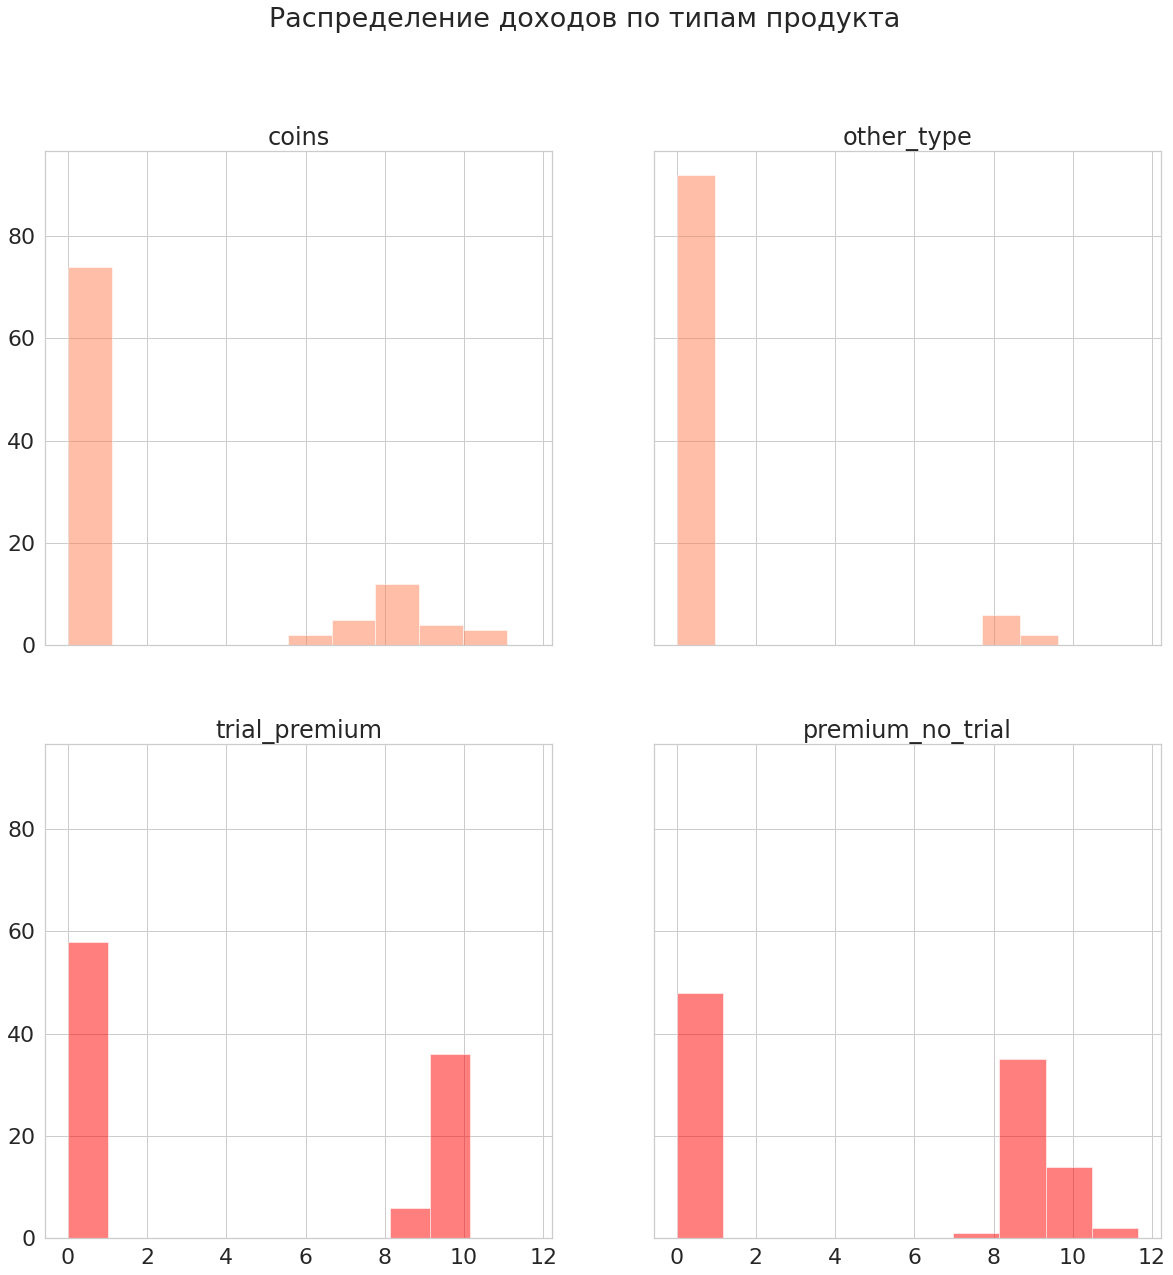

In [56]:
# Графики распределения

# import matplotlib.dates as mdates

#задаём значения для будущих осей
var1 = prod_types_tab.coins
var2 = prod_types_tab.other_type
var3 = prod_types_tab.trial_premium
var4 = prod_types_tab.premium_no_trial

#задаём сетку, совместное использование осей
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), sharey=True, sharex=True)

#заголовок
fig.suptitle('Распределение доходов по типам продукта', fontsize=27)

# подзаголовки графиков
axs[0, 0].set_title("coins")
axs[0, 1].set_title("other_type")
axs[1, 0].set_title("trial_premium")
axs[1, 1].set_title("premium_no_trial")


#добавляем данные на графики
axs[0, 0].hist(var1, alpha=0.5, color='coral')
axs[0, 1].hist(var2, alpha=0.5, color='coral')
axs[1, 0].hist(var3, alpha=0.5, color='red')
axs[1, 1].hist(var4, alpha=0.5, color='red')

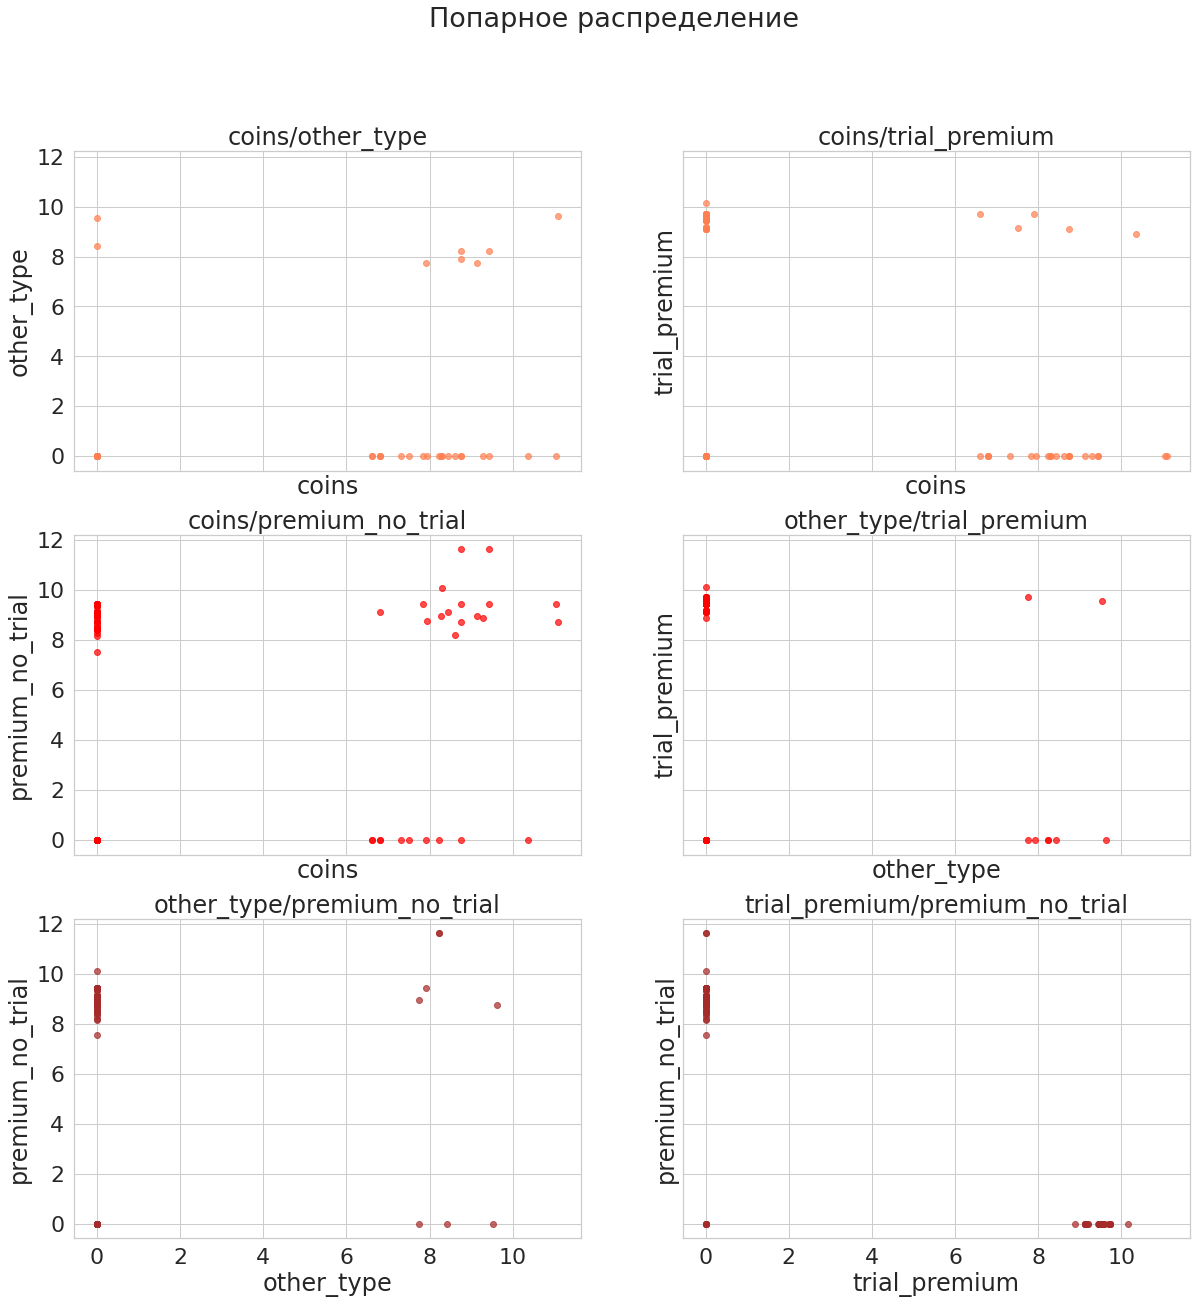

In [57]:
# Графики распределения значений

# import matplotlib.dates as mdates

#задаём значения для будущих осей
var1 = prod_types_tab.coins
var2 = prod_types_tab.other_type
var3 = prod_types_tab.trial_premium
var4 = prod_types_tab.premium_no_trial

#задаём сетку, совместное использование осей
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), sharey=True, sharex=True)

#заголовок
fig.suptitle('Попарное распределение', fontsize=27)

# подзаголовки графиков
axs[0, 0].set_title("coins/other_type")
axs[0, 1].set_title("coins/trial_premium")
axs[1, 0].set_title("coins/premium_no_trial")
axs[1, 1].set_title("other_type/trial_premium")
axs[2, 0].set_title("other_type/premium_no_trial")
axs[2, 1].set_title("trial_premium/premium_no_trial")

# подписи осей
axs[0, 0].set_xlabel("coins")
axs[0, 1].set_xlabel("coins")
axs[1, 0].set_xlabel("coins")
axs[1, 1].set_xlabel("other_type")
axs[2, 0].set_xlabel("other_type")
axs[2, 1].set_xlabel("trial_premium")

axs[0, 0].set_ylabel("other_type")
axs[0, 1].set_ylabel("trial_premium")
axs[1, 0].set_ylabel("premium_no_trial")
axs[1, 1].set_ylabel("trial_premium")
axs[2, 0].set_ylabel("premium_no_trial")
axs[2, 1].set_ylabel("premium_no_trial")

#добавляем данные на графики
axs[0, 0].scatter(var1, var2, alpha=0.7, color='coral')
axs[0, 1].scatter(var1, var3, alpha=0.7, color='coral')
axs[1, 0].scatter(var1, var4, alpha=0.7, color='red')
axs[1, 1].scatter(var2, var3, alpha=0.7, color='red')
axs[2, 0].scatter(var2, var4, alpha=0.7, color='brown')
axs[2, 1].scatter(var3, var4, alpha=0.7, color='brown')

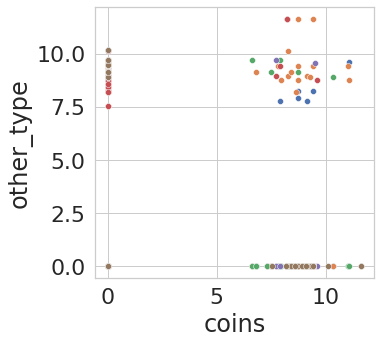

In [58]:
sns.scatterplot(data=prod_types_tab, x="coins", y="other_type")
sns.scatterplot(data=prod_types_tab, x="coins", y="premium_no_trial")
sns.scatterplot(data=prod_types_tab, x="coins", y="trial_premium")
sns.scatterplot(data=prod_types_tab, x="other_type", y="premium_no_trial")
sns.scatterplot(data=prod_types_tab, x="other_type", y="trial_premium")
sns.scatterplot(data=prod_types_tab, x="premium_no_trial", y="trial_premium")

In [59]:
# матрица корреляций
prod_types_tab.corr()

product_type,coins,other_type,premium_no_trial,trial_premium,premium_all
product_type,,,,,
coins,1.000000,0.361011,0.179297,-0.278938,-0.215286
other_type,0.361011,1.000000,0.097751,-0.094754,0.001072
premium_no_trial,0.179297,0.097751,1.000000,-0.880180,0.195189
trial_premium,-0.278938,-0.094754,-0.880180,1.000000,0.293711
premium_all,-0.215286,0.001072,0.195189,0.293711,1.000000


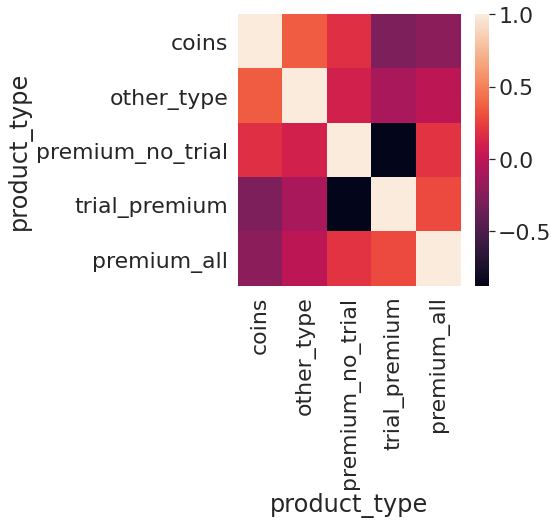

In [60]:
sns.heatmap(prod_types_tab.corr())

## Статистическая оценка эксперимента

Так как не обнаружено корреляции между coins, others и продуктами premium, для расчёта метрик и оценки эффекта от премимум можно использовать доходы от продуктов премиум.

На этапе анализа данных из датасетов были исключены дубликаты и пропущенные значения, а также отфильтрованы страны, тип оплаты и строки где дата регистрации позднее даты оплаты.
<br>В дальнейшем для АБ-теста берём датасеты test и control2.

<br><b>В блоке статистического анализа:</b>
<br><b>1)</b>Подготовим выборки с расчитанной метрикой
<br><b>2)</b>Проведём оценку распределений и выберем статистический критерий
<br><b>3)</b>Выполним оценку метрик статистическим тестом

<br><b>1)Готовим выборки</b>
<br>Для оценки среднего дохода на пользователя и среднего дохода на платящего пользователя будем использовать тесты с оценкой среднего, поэтому готовим таблицы с доходами на каждого пользователя.

In [61]:
# для test
# готовим таблицу для оценки arppu: агрегируем доход по пользователям в датасете с транзакциями, добавляем метку о покупке премиум
rppu_test = transactions_test \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum'}) \
    .assign(cr_mark = 1)
# готовим таблицу для оценки arpu: объединяем датасеты транзакций и пользователей
rpu_test = user_test \
    .merge(rppu_test, how='left', on='uid').fillna(0)
# готовим таблицу для оценки cr
cr_test = rpu_test.groupby('cr_mark', as_index=False).agg({'uid': 'count'})

# для control2
# готовим таблицу для оценки arppu: агрегируем доход по пользователям в датасете с транзакциями, добавляем метку о покупке премиум
rppu_control2 = transactions_control2 \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum'}) \
    .assign(cr_mark = 1)
# готовим таблицу для оценки arpu: объединяем датасеты транзакций и пользователей
rpu_control2 = user_control2 \
    .merge(rppu_control2, how='left', on='uid').fillna(0)
# готовим таблицу для оценки cr
cr_control2 = rpu_control2.groupby('cr_mark', as_index=False).agg({'uid': 'count'})

In [62]:
rppu_test.head(10)

,uid,revenue,cr_mark
0,891071157,9100,1
1,891152790,12597,1
2,891178380,113477,1
3,891222282,6292,1
4,891291531,4056,1
5,891312873,7852,1
6,891318459,7826,1
7,891325683,4719,1
8,891346269,12597,1
9,891352467,6370,1


In [63]:
rpu_test.tail(10)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue,cr_mark
4215,891291531,43,372,0.0,Germany,"1,2,3,4,5,6,7",1,40,46,59,1.0,1.0,4056,4056.0,1.0
4216,891078231,29,500,0.0,United States of America,0,1,26,32,2,0.0,0.0,0,0.0,0.0
4217,891430119,22,0,0.0,Spain,2,1,19,25,1,0.0,0.0,0,0.0,0.0
4218,891668958,30,0,0.0,Germany,0,1,27,33,0,0.0,0.0,0,0.0,0.0
4219,891063408,35,578,0.0,Israel,"1,2,3,4,5",0,32,38,1347,0.0,0.0,0,0.0,0.0
4220,891078639,17,895,0.0,United States of America,"1,2,3,4,5",1,16,20,96,0.0,0.0,0,0.0,0.0
4221,891188733,27,866,0.0,United States of America,"1,2,3",1,18,41,30,0.0,0.0,0,0.0,0.0
4222,891293718,48,0,0.0,Argentina,0,1,47,51,10,0.0,0.0,0,0.0,0.0
4223,891192357,32,0,0.0,Australia,0,1,16,49,0,0.0,0.0,0,0.0,0.0
4224,891668910,35,575,0.0,United Arab Emirates,1,1,16,99,73,0.0,0.0,0,0.0,0.0


In [64]:
# количество сконвертировавшихся и нет пользователей
cr_test

,cr_mark,uid
0,0.0,4174
1,1.0,51


In [65]:
cr_control2

,cr_mark,uid
0,0.0,4095
1,1.0,89


<br><b>2)Оценка распределений и выбор статистического критерия</b>
<br>Посмотрим на гистограммы метрик по странам.

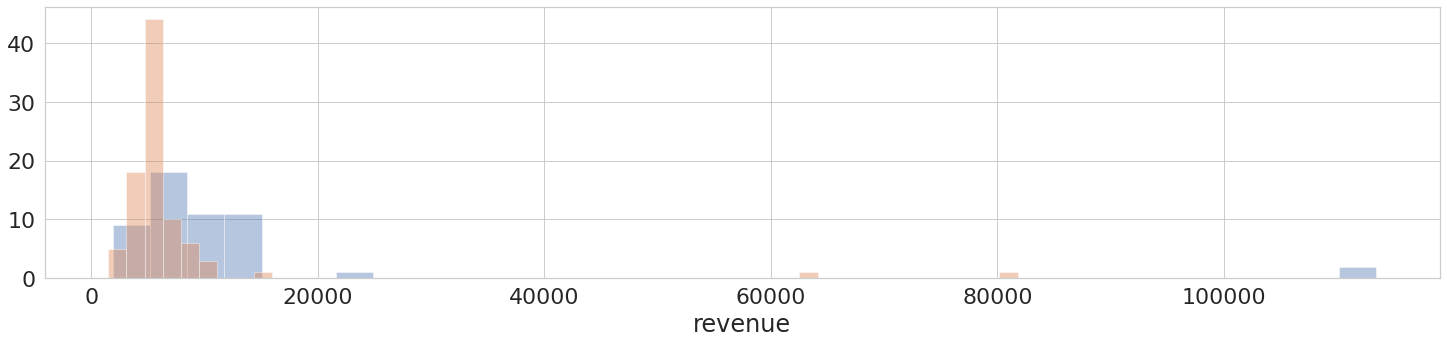

In [66]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(25,5)}
        )
# распределение доходов по платящим пользователям
sns.distplot(rppu_test.revenue, kde=False)
sns.distplot(rppu_control2.revenue, kde=False)

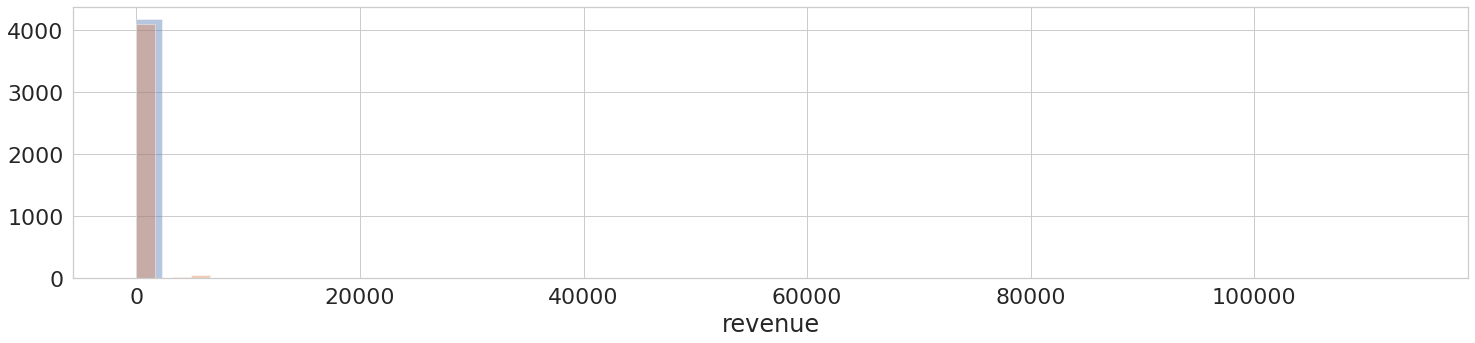

In [67]:
# распределение доходов по пользователям
sns.distplot(rpu_test.revenue, kde=False)
sns.distplot(rpu_control2.revenue, kde=False)

По графикам rppu распределения похожи на нормальные со смещённым вправо хвостом, график rpu не показателен т.к. смещён к 0. Прогоним выборки через тест на нормальность.
<br><b><i>H0:</i></b> выборка принадлежит генеральной совокупности с нормальным распределением.

In [68]:
# тест на нормальность распределения по контрольным и тестовым выборкам для доходов по всем пользователям и по платящим
print(f'normal_tests')
print(f'rppu_test_norm  {st.normaltest(rppu_test.revenue)}')
print(f'rppu_control2_norm  {st.normaltest(rppu_control2.revenue)}')
print(f'rpu_test_norm  {st.normaltest(rpu_test.revenue)}')
print(f'rpu_control2_norm  {st.normaltest(rpu_control2.revenue)}')

normal_tests
rppu_test_norm  NormaltestResult(statistic=82.89980780251145, pvalue=9.966334522097274e-19)
rppu_control2_norm  NormaltestResult(statistic=149.97081719795628, pvalue=2.7180085728475616e-33)
rpu_test_norm  NormaltestResult(statistic=11966.281557324095, pvalue=0.0)
rpu_control2_norm  NormaltestResult(statistic=11207.429928589361, pvalue=0.0)


<br><b><i>H0</i></b> что выборки принадлежат ГС с нормальным распределением не подтверждается, p-value < 0,05 для всех выборок (test, control2) для rpu и rppu.

Проверим распределение средних для выборок test, control2 для rpu и rppu.
<br><b><i>H0:</i></b> средние выборок принадлежат ГС с нормальным распределением.

Populating the interactive namespace from numpy and matplotlib


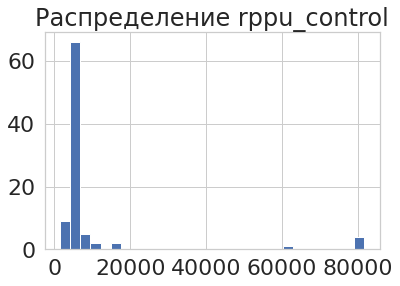

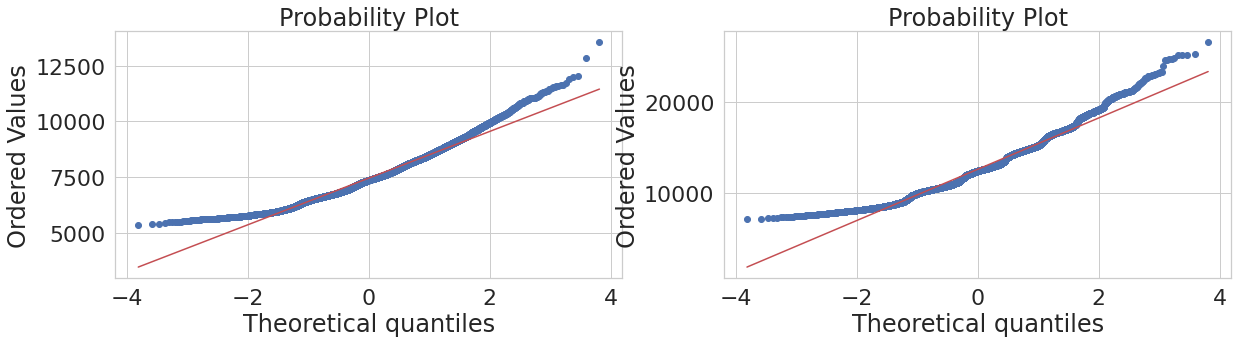

Тест на нормальность распределения control группы: W = 0.970 , p-value = 0.000 => стат значимо не нормально
Тест на нормальность распределения target группы: W = 0.969 , p-value = 0.000 => стат значимо не нормально


In [69]:
# оценка распределения средних тестовой и контрольной выборок для rppu
%pylab inline

sample_means_control = []
sample_means_target = []
# симулируем выборку
for i in range(10000):
    sample_control = rppu_control2.revenue.sample(frac=1, replace=True)
    sample_target = rppu_test.revenue.sample(frac=1, replace=True)
    sample_means_control.append(sample_control.mean())
    sample_means_target.append(sample_target.mean())


# График rppu_control2
count, bins, ignored = plt.hist(sample_control, 30)
plt.title('Распределение rppu_control')
plt.show()


# Q-Q plots для control и target групп
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
st.probplot(sample_means_control, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
st.probplot(sample_means_target, dist="norm", plot=pylab)
pylab.show()


# тест на нормальность распределения Шапиро-Уилка
sp = st.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1] > 0.05 else '=> стат значимо не нормально'
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)


sp = st.shapiro(sample_means_target)
concl = '=> не стат значимо, нормальное' if sp[1] > 0.05 else '=> стат значимо не нормально'
print('Тест на нормальность распределения target группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

Populating the interactive namespace from numpy and matplotlib


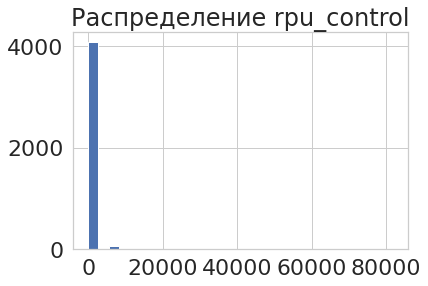

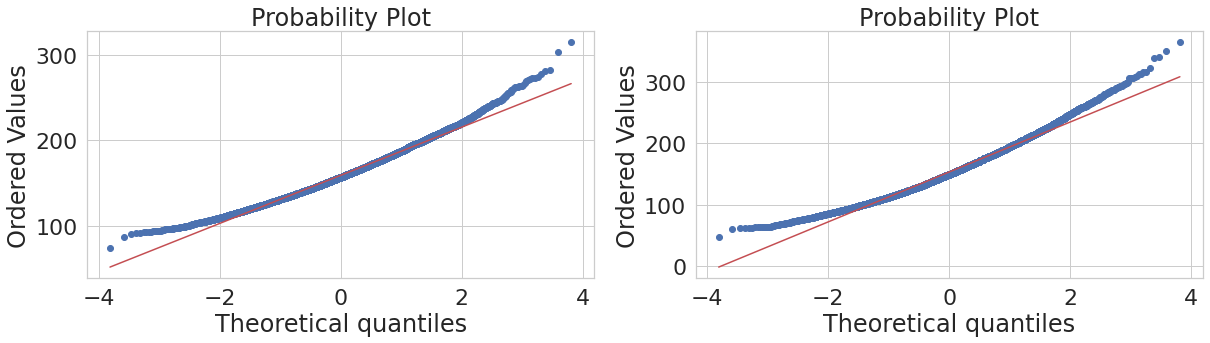

Тест на нормальность распределения control группы: W = 0.987 , p-value = 0.000 => стат значимо не нормально
Тест на нормальность распределения target группы: W = 0.980 , p-value = 0.000 => стат значимо не нормально


In [70]:
# оценка распределения средних тестовой и контрольной выборок для rpu
%pylab inline

sample_means_control = []
sample_means_target = []
# симулируем выборку
for i in range(10000):
    sample_control = rpu_control2.revenue.sample(frac=1, replace=True)
    sample_target = rpu_test.revenue.sample(frac=1, replace=True)
    sample_means_control.append(sample_control.mean())
    sample_means_target.append(sample_target.mean())


# График rpu_control2
count, bins, ignored = plt.hist(sample_control, 30)
plt.title('Распределение rpu_control')
plt.show()


# Q-Q plots для control и target групп
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
st.probplot(sample_means_control, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
st.probplot(sample_means_target, dist="norm", plot=pylab)
pylab.show()


# тест на нормальность распределения Шапиро-Уилка
sp = st.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1] > 0.05 else '=> стат значимо не нормально'
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)


sp = st.shapiro(sample_means_target)
concl = '=> не стат значимо, нормальное' if sp[1] > 0.05 else '=> стат значимо не нормально'
print('Тест на нормальность распределения target группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

In [71]:
print(f'size')
print(f'rppu_test  {rppu_test.shape}')
print(f'rppu_control2  {rppu_control2.shape}')
print(f'rpu_test  {rpu_test.shape}')
print(f'rpu_control2  {rpu_control2.shape}')

size
rppu_test  (52, 3)
rppu_control2  (89, 3)
rpu_test  (4225, 15)
rpu_control2  (4184, 15)


<br><b><i>H0</i></b> не подверждается, средние выборок test, control2 для rpu и rppu не принадлежат ГС с нормальным распределением.

<br>Но условие нормальности распределений не является обязательным для больших выборок (> 30).
<br>Проверим условие гомогенности дисперсий
<br><b><i>H0:</i></b> дисперсии не отличаются

In [72]:
st.levene(rppu_test.revenue, rppu_control2.revenue, center='median')

LeveneResult(statistic=2.649927488726874, pvalue=0.10581922146482738)

In [73]:
st.levene(rpu_test.revenue, rpu_control2.revenue, center='median')

LeveneResult(statistic=0.009668708810390298, pvalue=0.9216729246335452)

<br><b><i>H0</i></b> подтвердилась дисперсии для выборок test, control2 для rpu и rppu действительно не отличаются, p-value > 0.05

<br><b>3)Проведём оценку распределения доходов на пользователя и платящего пользователя</b>
<br>Для проведения <i>t-теста Стьюдента</i> не выполняется требование о нормальности распределения средних выборок, непараметрические критерии <i>Манна-Уитни</i> использовать не могу т.к. <b><i>H0</i></b> не соответствует рассчитываемой метрике (нужно оценивать средние, а Манна-Уитни сравнивает ранги в объединенной выборке), то же самое для двухвыборочного критерия однородности <i>Колмогорова-Смирнова</i> (H0 два распределения идентичны), <i>критерий Уэлча</i> выбирают, если распределение нормально и дисперсии неравны, а у нас распределения ненормальны и дисперсии равны. 
<br>В целом для больших выборок (> 30) нормальность средних не является обязательным условием для проведения <i>t-теста Стьюдента</i> и формально условие о размере выборок соблюдается (выборки > 52строк), однако для достоверного эффекта будем использовать метод, который позволит увеличить выборку и на больших примерах быть объективнее.
<br>Применим <i>bootstrap</i> для оценки метрик средний доход на покупателя и средний доход на пользователя. Будем оценивать распределение разницы средних значений по выборкам, т.е. распределение разницы среднего дохода контрольной и тестовой групп.
<br>Так как используем данные реальных экспериментов, примем, что условие "выборка хорошо отображает/моделирует ГС" выполняется.

<br>Оценим основную метрику <b>ARPU</b>.
<br><b><i>H0:</i></b> Выборочные средние выборок находятся в пределах одной ГС.

(Выборочные средние значения дохода на пользователя от покупки премиум-подписки от выборок пользователей с новым типом оплаты и без находятся в пределах одной генеральной совокупности).

In [74]:
# st.ttest_ind(rpu_test.revenue, rpu_control2.revenue)
# st.ttest_ind(rppu_test.revenue, rppu_control2.revenue)
# st.ks_2samp(data1=rppu_test.revenue, data2=rppu_control2.revenue) Колмогорова

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

*Функция get_bootstrap взята из занятия по АБ тестам karpov.courses от команды experiment-fest

In [81]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('coral')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

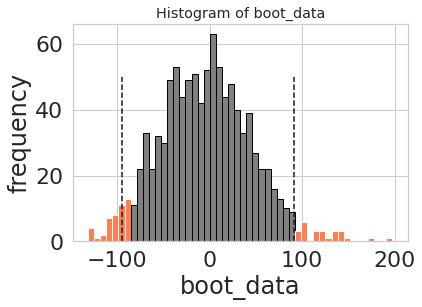

{'boot_data': [-47.12,
  15.636923076923077,
  -2.5784615384615384,
  -1.7076923076923076,
  60.36923076923077,
  4.9169230769230765,
  1.7415384615384615,
  45.31076923076923,
  -14.126153846153846,
  11.141538461538461,
  -10.504615384615384,
  44.87384615384615,
  40.433846153846154,
  -23.526153846153846,
  -78.31692307692308,
  -27.97230769230769,
  51.36615384615384,
  -71.64,
  -33.80923076923077,
  68.14461538461538,
  -100.34461538461538,
  48.53846153846154,
  -51.82769230769231,
  23.978461538461538,
  8.756923076923076,
  132.12307692307692,
  7.292307692307692,
  -11.673846153846155,
  -18.34769230769231,
  -13.467692307692309,
  28.944615384615386,
  50.473846153846154,
  18.335384615384616,
  -41.027692307692305,
  32.81846153846154,
  66.80615384615385,
  -65.92,
  -4.7907692307692304,
  -67.31692307692308,
  56.144615384615385,
  -25.44923076923077,
  -0.31384615384615383,
  81.57846153846154,
  146.92,
  48.55384615384615,
  89.58769230769231,
  -96.43692307692308,
  

In [82]:
# Выводим оценку выборок rpu для основной метрики ARPU
get_bootstrap(
    rpu_test.revenue, # числовые значения первой выборки
    rpu_control2.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Оценим вспомогательную метрику <b>ARPPU</b>.
<br><b><i>H0:</i></b> Выборочные средние выборок находятся в пределах одной ГС (Выборочные средние значения дохода на покупателя от покупки премиум-подписки от выборок пользователей с новым типом оплаты и без находятся в пределах одной генеральной совокупности).

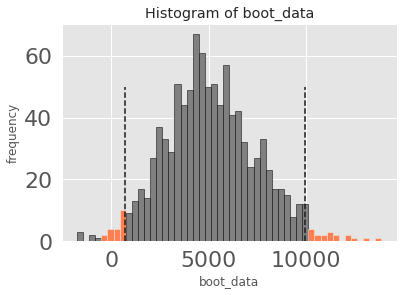

{'boot_data': [3652.85393258427,
  766.8539325842696,
  5924.056179775281,
  3394.0224719101125,
  4282.258426966292,
  1076.808988764045,
  3573.8314606741574,
  8999.067415730337,
  4342.0,
  5215.191011235955,
  6191.067415730337,
  6210.056179775281,
  466.97752808988764,
  5146.9775280898875,
  4318.775280898876,
  1656.258426966292,
  6816.820224719101,
  9654.76404494382,
  4219.157303370786,
  7028.033707865168,
  4709.943820224719,
  7696.5842696629215,
  1681.0898876404494,
  8243.898876404495,
  7692.056179775281,
  7753.258426966292,
  6141.258426966292,
  4245.741573033708,
  8576.786516853932,
  7623.112359550561,
  5186.853932584269,
  3627.14606741573,
  5615.269662921349,
  4842.865168539326,
  1549.191011235955,
  5441.449438202248,
  7542.483146067416,
  9483.280898876405,
  7995.730337078651,
  3195.808988764045,
  8454.52808988764,
  7057.9775280898875,
  2085.9887640449438,
  5138.213483146067,
  5240.314606741573,
  3454.0561797752807,
  2918.1348314606744,
  522

In [83]:
# Выводим оценку выборок rppu для вспомогательной метрики ARPPU
get_bootstrap(
    rppu_test.revenue, # числовые значения первой выборки
    rppu_control2.revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [105]:
# соотношение средего дохода тестовой к контрольной группе
print(rppu_test.revenue.mean() / rppu_control2.revenue.mean())
print(rpu_test.revenue.mean() / rpu_control2.revenue.mean())

1.691235713229949
0.9690538739750082


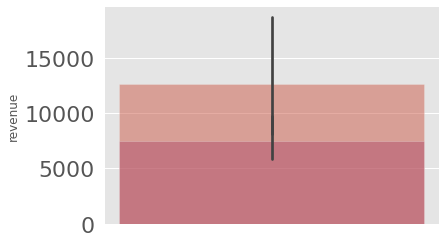

In [103]:
#средний доход на покупателя в тестово и контрольно группе 
sns.barplot(y='revenue', data=rppu_test, alpha=0.5)
sns.barplot(y='revenue', data=rppu_control2, alpha=0.5, palette='flare')

<br><b><i>H0</i></b>, что выборочные средние выборок находятся в пределах одной ГС подтвердилась для основной метрики. Средний доход на пользователя (p-value = 0.9) не изменился от ввода новых типов платежа.
<br><b><i>H0</i></b>, что выборочные средние выборок находятся в пределах одной ГС не подтвердилась для вспомогательной метрики. Средний доход на платящего пользователя (p-value = 0.022) изменился от ввода новых типов платежа.
<br>Иными словами нам не удалось задетектировать uplift или падение ключевой метрики ARPU и найти статистически значимый эффект.
<br>В то же время по графику среднего дохода на покупателя видим рост впомогательной метрики ARPPU почти в 2 раза.

Посмотрим ещё одну вспомогательную метрику CR, по графику едва заметные различия.

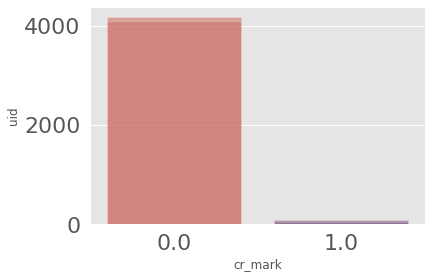

In [106]:
sns.barplot(x='cr_mark', y='uid', data=cr_test, alpha=0.5)
sns.barplot(x='cr_mark', y='uid', data=cr_control2, alpha=0.5, palette='flare')
# sns.distplot(rppu_control2.revenue, kde=False)

Оценим выборки статистически методом Хи-квадрат.
<br>Требования соблюдаются:
1. Все наблюдения независимы
2. Количество наблюдений в каждой ячейке больше 5

<br><b><i>H0:</i></b> влияния новых систем оплаты нет, изменения зависимости по контрольной и тестовой выборкам между количеством сконвертировашихся и нет пользователей не будет.

In [107]:
cr_control2.merge(cr_test, on='cr_mark')

,cr_mark,uid_x,uid_y
0,0.0,4095,4174
1,1.0,89,51


In [108]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(cr_control2.merge(cr_test, on='cr_mark'))
stat, p

(69.44722923621237, 8.312387481236826e-16)

<br>Можем статистически значимо отклонить <b><i>H0</i></b>, p-value < 0.05

In [109]:
print(f'cr_control  {cr_control2.uid[1] / cr_control2.uid[0] * 100}')
print(f'cr_test  {cr_test.uid[1] / cr_test.uid[0] * 100}')

cr_control  2.173382173382173
cr_test  1.2218495448011502


Изменение системы оплаты незначительно влияет на количество сконвертировавшихся пользователей, количество таких пользователей в тестовой выборке упало на 1%.

### Рекомендации к источникам:
- Выяснить причину дублирования транзакций в датасетах
- Выяснить причину наличия логов даты покупки раньше даты регистрации
- Обратить внимание на несоответствие стран в датасетах пользователей

### Выводы по результатам АБ-теста:
<br>Статистическая оценка основной метрики ARPPU не показала значимых отличий тестовой и контрольной выборок. Эксперимент не позволил задетектировать uplift или падение основной метрики.

В то же время удалось обнаружить изменение вспомогательных метрик: увеличение метрики ARPPU (в 1,96 раз) и незначительное снижение CR в покупку подписки премиум (эффект - падение на ~ 1%), задетектированные методом bootstrap на разнице средних по выборкам и Хи-квадрат соответственно. 

<br>Ввод новых систем оплаты незначительно поменял механизм получения дохода: уменьшилась конверсия в покупку премиум-подписки и вырос средний доход от покупателя. Т.е. часть пользователей простимулированы больше тратить, а часть пользователей вовсе отказалась от расходов на премиум-подписку. По итогу изменение механики системы оплат не оказало влияния на доходы приложения знакомств в целом.

<br>На данном этапе не можем рекомендовать раскатку новых систем оплаты подписки премиум на всех пользователей. Но можем предложить запустить новый эксперимент одновременно с вводом новых типов оплат премиум-подписки добавить активность или фичу, которая повышает CR из пользователя в покупку.